In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.manifold import TSNE
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import matthews_corrcoef, accuracy_score, make_scorer
from tqdm.notebook import tqdm, tnrange
np.set_printoptions(suppress=True)


import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from BNN_utils import *
from classification_utils import *
pd.set_option('display.max_columns', None)

In [2]:
def expected_calibration_error(y, y_hat, N_bins=10):

    """
    Compute the expected calibration error. 
    """

    y , y_hat = y.cpu() , y_hat.cpu()
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    counts = []
    acc = []
    conf = []
    for k in range(N_bins):
        count = len(y[which_bin==k])
        if count > 0:
            acc.append(y[which_bin==k].float().mean().item())
            conf.append(y_hat[which_bin==k].float().mean().item())
        else:
            acc.append(0.0)
            conf.append(0.0)
        counts.append(count)
    return ((np.abs(np.array(acc) - np.array(conf))*np.array(counts))/len(y)).sum()

In [3]:
rand_state = 1 # random seed used in every place which take a seed as input

data = pd.read_csv('cross_sectional_data.csv', index_col=[0])
X , y = encode(data.drop(columns=['ID', 'Labels'])) , data['Labels'].to_numpy()
# Fix missing values
col_list = list(X.columns.values)
X = X.reindex(columns=col_list).fillna(0)
X = X[col_list]
X_numeric = X.iloc[: , :8]

# Standardize numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric, columns=encode(data.drop(columns=['ID', 'Labels'])).columns.values[:8])
X = pd.concat([X_numeric, X.iloc[:, 8:]], axis=1)
X = X.drop(columns=['r2', 'slope']) # remove these two features since they won't be available in case of model deployment

# Split data to training, validation and test sets
test_size = 0.15
valid_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size + valid_size, random_state = rand_state, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = test_size / (valid_size + test_size), random_state = 12761 * rand_state, stratify = y_test)


######################################################
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state) # can use skf.split(X_train, y_train) to get the indices of the folding (useful when working with BNN and GP to make test set predictions)
######################################################

c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
torch.manual_seed(1)

class simpleNet(nn.Module):
    
    def __init__(self, feature_dim):
        super().__init__()

        # Feature extraction part --> Outputs feature matrix
        self.feature_extr = nn.Sequential(nn.Linear(feature_dim, 100),
                        nn.ReLU(), 
                        nn.Linear(100, 1000),
                        nn.ReLU(),
                        nn.Linear(1000, 500),
                        nn.ReLU(), 
                        nn.Linear(500, 1000),
                        nn.ReLU(),
                        nn.Linear(1000, 2000),
                        nn.ReLU(),
                        nn.Linear(2000, 500))

        # Use the resulting feature matrix from above in a linear layer: i.e. y = w' φ(x)
        self.clf = nn.Linear(500, 3, bias=True)
        
    def forward(self, x):
        x = self.feature_extr(x)

        return self.clf(x)

## Bayesian last layer with a Laplace approximation for the posterior

Here we use a Kronecker factored approximation for the covariance matrix of the posterior

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Create tensors and send to GPU
X_train = torch.from_numpy(X_train.values).float().to(device)
X_test = torch.from_numpy(X_test.values).float().to(device)
X_valid = torch.from_numpy(X_valid.values).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_valid = torch.from_numpy(y_valid).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [6]:
train_model = False

if train_model:

    # Instantiate the model
    bll_model = simpleNet(feature_dim=X_train.shape[1]).to(device)

    opt = optim.SGD(bll_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    n_epochs = 100_000

    # Train the model with early stopping using a validation set
    bll_model, train_loss, valid_loss = train_model(bll_model, X_train, X_valid, y_train, y_valid, patience=100, n_epochs=n_epochs, optimizer=opt, criterion=nn.CrossEntropyLoss())

    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0.5, 1.2) # consistent scale
    plt.xlim(0, len(train_loss) + 20) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
# Test set prediction using the Laplace approximation to the posterior

use_best_weights = True

if use_best_weights: # Use best weights already found
  # Instantiate the model
  bll_model = simpleNet(feature_dim=X_train.shape[1]).to(device)

  if not torch.cuda.is_available():
    bll_model.load_state_dict(torch.load(f'weights/best_weights_seed_{rand_state}.pt', map_location=torch.device('cpu')))
  else:
    bll_model.load_state_dict(torch.load(f'weights/best_weights_seed_{rand_state}.pt'))

W = list(bll_model.parameters())[-2].to(device) # last layer model weights (excluding last layer intercept term)
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(bll_model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(bll_model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac
A.to(device)
B.to(device)

# The weight decay used for training is the Gaussian prior's precision
prec0 = torch.tensor(5e-4).to(device)

# The posterior covariance's Kronecker factors
U = torch.inverse(A + torch.sqrt(prec0).to(device) * torch.eye(shape_W[0]).to(device))
V = torch.inverse(B + torch.sqrt(prec0).to(device) * torch.eye(shape_W[1]).to(device))


# Get the posterior covariance and make prediction
y_pred_bayes, pred_probs_bayes = laplace_predict(X_test, bll_model, W, U, V)

print(f'Test set accuracy: {(y_pred_bayes == y_test).float().mean().item() :.3f}')
print(f'Test set MCC: {matthews_corrcoef(y_test.cpu().numpy(), y_pred_bayes.cpu().numpy()) :.3f}')

Test set accuracy: 0.753
Test set MCC: 0.331


## Let's investigate the model uncertainty using the Bayesian last layer model and its non-Bayesian counterpart 

ECE = 0.3902


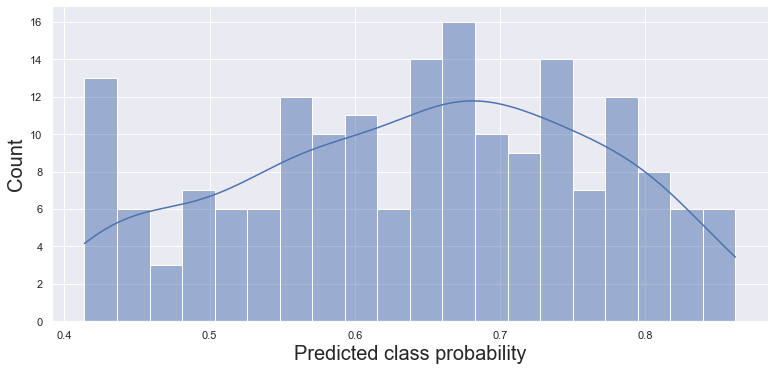

In [8]:
bayes_pred_probs_highest = pred_probs_bayes.max(axis=1)[0].cpu()
print("ECE = %0.4f" % expected_calibration_error(y_test, bayes_pred_probs_highest))

sil_plot = sns.displot(bayes_pred_probs_highest, kde=True, bins=20)
sil_plot.fig.set_figheight(5)
sil_plot.fig.set_figwidth(12)
sil_plot.set_xlabels('Predicted class probability', fontsize=20)
sil_plot.set_ylabels('Count', fontsize=20);
sil_plot.set_titles('Bayesian neural network', fontsize=24);

Test set accuracy: 0.725
Test set MCC: 0.211
ECE = 0.4487


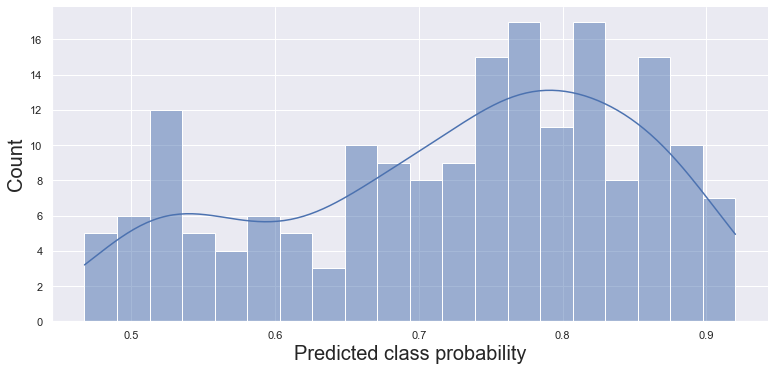

In [9]:
# Let's see the predicted prbabilities resulting from a non-Bayesian NN
with torch.no_grad():
  logits_pred_non_bayes = bll_model(X_test)

probs_pred_non_bayes = torch.softmax(logits_pred_non_bayes, axis=1)
y_pred_non_bayes = probs_pred_non_bayes.argmax(axis=1)
highest_prob_non_bayes = probs_pred_non_bayes.max(axis=1)[0]
non_bayes_pred_probs = highest_prob_non_bayes.cpu()

print(f'Test set accuracy: {(y_pred_non_bayes == y_test).float().mean().item() :.3f}')
print(f'Test set MCC: {matthews_corrcoef(y_test.cpu().numpy(), y_pred_non_bayes.cpu().numpy()) :.3f}')
print("ECE = %0.4f" % expected_calibration_error(y_test, probs_pred_non_bayes.max(axis=1)[0]))

sil_plot = sns.displot(non_bayes_pred_probs, kde=True, bins=20)
sil_plot.fig.set_figheight(5)
sil_plot.fig.set_figwidth(12)
sil_plot.set_xlabels('Predicted class probability', fontsize=20)
sil_plot.set_ylabels('Count', fontsize=20);
sil_plot.set_titles('Standard neural network', fontsize=24);

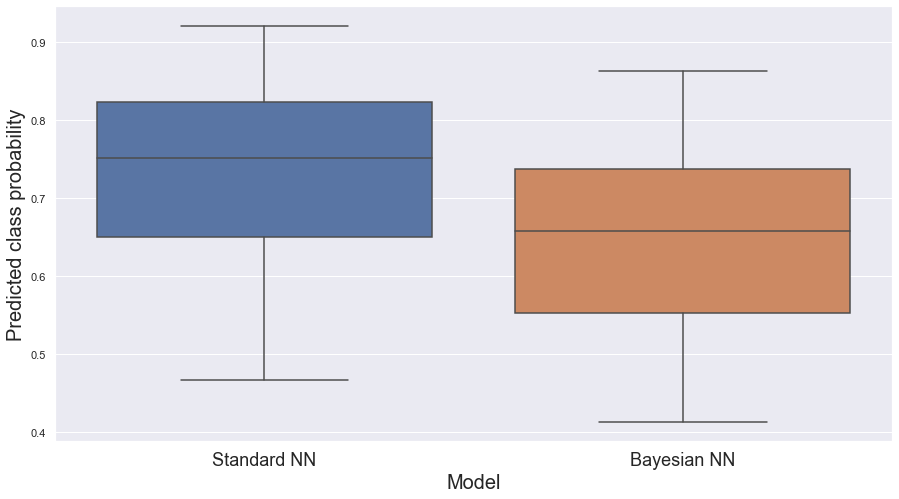

In [10]:
model_probs = pd.DataFrame({'Standard NN' : non_bayes_pred_probs.numpy(), 'Bayesian NN' : bayes_pred_probs_highest.numpy()})

plt.figure(figsize=(15,8))
sil_plot = sns.boxplot(x="variable", y="value", data=pd.melt(model_probs)); 
plt.xlabel('Model', fontsize=20)
plt.ylabel('Predicted class probability', fontsize=20);
plt.xticks(fontsize=18);

## Let's also analyse the probabilities for misclassified data points

In [11]:
bayes_misclass_probs = bayes_pred_probs_highest[y_pred_bayes != y_test]
non_bayes_misclass_probs = non_bayes_pred_probs[y_pred_non_bayes != y_test]

print(f'Bayesian NN predicted class probabilities on misclassified datapoints:  Mean prob. = {bayes_misclass_probs.mean().item() :.3f},  Median prob. = {bayes_misclass_probs.median().item():.3f}')
print(f'Standard NN predicted class probabilities on misclassified datapoints:  Mean prob. = {non_bayes_misclass_probs.mean().item() :.3f},  Median prob. = {non_bayes_misclass_probs.median().item():.3f}')

Bayesian NN predicted class probabilities on misclassified datapoints:  Mean prob. = 0.594,  Median prob. = 0.577
Standard NN predicted class probabilities on misclassified datapoints:  Mean prob. = 0.655,  Median prob. = 0.619


We can clearly see that being Bayesian, even if only with regards to just the last layer of the network can improve the overconfidence issue which is often the case with standard neural networks. In medical settings, being able to quantify the confidence in a prediction is really important and so even though Bayesian NNs might not provide improved predictive performance over standard NNs, their better calibrated prediction uncertainty makes them quite attractive in such settings. 

## BNN using SGLD for last layer weights posterior sampling

In [12]:
draw_samples = False

if draw_samples: # Draw MCMC samples using SGLD
  SGLD_samples = draw_sgld_samples(bll_model, X_train, y_train, N_samples=5000, N_steps_per_sample=200)

else: # Load MCMC samples 
  
  if torch.cuda.is_available():
    SGLD_samples = torch.load(f'mcmc_samples/sgld_samples_seed_{rand_state}.pt')
  else:
    SGLD_samples = torch.load(f'mcmc_samples/sgld_samples_seed_{rand_state}.pt', map_location=torch.device('cpu'))

with torch.no_grad():
  y_hat_mcmc = predict_from_posterior_samples(X_test, bll_model, SGLD_samples)
  SGLD_preds = y_hat_mcmc.argmax(axis=1)
  SGLD_pred_probs = y_hat_mcmc.max(axis=1)[0]

print(f'Test set accuracy: {(SGLD_preds == y_test).float().mean().item() :.3f}')
print(f'Test set MCC: {matthews_corrcoef(y_test.cpu().numpy(), SGLD_preds.cpu().numpy()) :.3f}')
print("ECE = %0.4f" % expected_calibration_error(y_test, SGLD_pred_probs))

Test set accuracy: 0.725
Test set MCC: 0.211
ECE = 0.4487
